# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [1]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter
%matplotlib inline

a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

Column names:
['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'Dew', 'Temperature', 'Pressure', 'Wind_Direction', 'Wind_Speed', 'Snow', 'Rain'] 

   No  year  month  day  hour  pm2.5  Dew  Temperature  Pressure  \
0   1  2010      1    1     0    NaN  -21        -11.0    1021.0   
1   2  2010      1    1     1    NaN  -21        -12.0    1020.0   
2   3  2010      1    1     2    NaN  -21        -11.0    1019.0   
3   4  2010      1    1     3    NaN  -21        -14.0    1019.0   
4   5  2010      1    1     4    NaN  -20        -12.0    1018.0   

  Wind_Direction  Wind_Speed  Snow  Rain  
0             NW        1.79     0     0  
1             NW        4.92     0     0  
2             NW        6.71     0     0  
3             NW        9.84     0     0  
4             NW       12.97     0     0   

Wind Direction values:
['NW' 'cv' 'NE' 'SE'] 



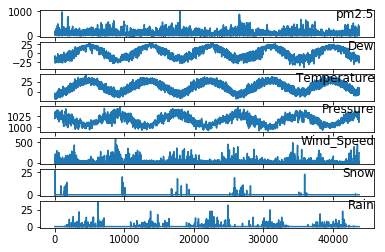

'\nAnalysis:\n    We see that the graphs are what we would expect.\n    Such as temperatue and pressure showing an inverse relationship which is \n    known by the laws of physics.\n'

In [2]:
# write your code here
""" Storing data into a pandas dataframe """

df = pd.read_csv("pollution.csv")

""" Data Exploration """

# fetch column names
cols = list(df)
print("Column names:")
print(cols, "\n") 

# see the first few rows
print(df.head(), "\n")

# Checking categories in wind direction
wd = df["Wind_Direction"].unique()
print("Wind Direction values:")
print(wd, "\n")


### Analysis ###
# We see that we need to combine date and times.
# ALso must fill missing values and drop "No" column because it is useless.
# Wind direction has some values named "cv". They will be treated as missing 
# values. One can either leave them as they are or remove all records from df 
# with these values. I will leave them as they are. 


""" Preprocessing """

def parser(x):
    """
    Function to parse the dates and times in the dataframe
    """
    return datetime.strptime(x, "%Y %m %d %H")

# parsing dates and times
df = pd.read_csv("pollution.csv", 
                 parse_dates = [["year", "month", "day", "hour"]], 
                 index_col=0, 
                 date_parser=parser)

# dropping "No" column
df.drop("No", axis=1, inplace=True)  # inplace is used to avoid creating a new df

# removing the 1st day because it is all missing values
df = df[24:]

# filling nan values
df["pm2.5"].fillna(0, inplace=True)

# New column names
cols = list(df)


""" Plotting data """

# remove WD from plot because it is categorical data
plot_cols = cols[:]
plot_cols.remove("Wind_Direction")

# plotting numerical data
i=1
plt.figure()  # create plot
for col in plot_cols:
    plt.subplot(len(plot_cols), 1, i)  #defining size of subplot and index
    plt.plot(df[col].values)  # values to plot
    plt.title(col, y=0.5, loc='right')  # plot title
    i += 1
plt.show()


"""
Analysis:
    We see that the graphs are what we would expect.
    Such as temperatue and pressure showing an inverse relationship which is 
    known by the laws of physics.
"""


b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [3]:
from sklearn import preprocessing
from keras.preprocessing.sequence import TimeseriesGenerator

# write your code here

""" Encoding wind direction """

# encoding wind direction because it is categorical data
encoder = preprocessing.LabelEncoder()
df["Wind_Direction"] = encoder.fit_transform(df["Wind_Direction"].values)


""" Creating train, validation and test sets """

# train using first 4 years
hrs = 365*24*4

# take 10% of train data as validation data
val_hrs = int(0.9*hrs)

# Create lists to store datasets
train = []
val = []
test = []

# loop to separate data into train, validatio and test sets
for i in cols:
    df[i] = df[i].astype(float)  # convert all data to float

# train and validation set
train_n_val = df[:hrs].values

# train set
train = train_n_val[:val_hrs]

# validation set
val = train_n_val[val_hrs:]

# test set
test = df[hrs:].values


""" Creating data generators """

# number of features is 8
n_features = df.shape[1]

# how many days before current should be used to predict 
days = 1

### batch size for training ###
# Increase this to decrease runtime, but causes a decreases in performance too
# My test on initial model was carried out on bath size of 1.
# This gave RMSE ~25.92
# Batch = 8 gives RMSE ~63.79
batch = 8

# generates time series values for train data
train_generator = TimeseriesGenerator(
        train, 
        df["pm2.5"][:val_hrs].values, 
        length=days, 
        batch_size=batch
        )

# generates time series values for validation data
val_generator = TimeseriesGenerator(
        val, 
        df["pm2.5"][val_hrs:hrs].values, 
        length=days, 
        batch_size=batch)

# generates time series values for test data
test_generator = TimeseriesGenerator(
        test, 
        df["pm2.5"][hrs:].values, 
        length=days, 
        batch_size=batch)


# prints number of samples
print("Samples: {}".format(len(train_generator)))

# Set batch size to 1 and then uncomment below to see features and target value
## prints each sample to check that correct features are being used
#for i in range(5):
#    x,y = train_generator[i]
#    print("{} => {}".format(x, y))
#    
#    


Using TensorFlow backend.


Samples: 3942


c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
3942/3942 [==============================] - 9s 2ms/step - loss: 14491.8996 - val_loss: 10749.0082
Epoch 2/20
3942/3942 [==============================] - 8s 2ms/step - loss: 11013.7903 - val_loss: 8444.7123
Epoch 3/20
3942/3942 [==============================] - 7s 2ms/step - loss: 9107.7283 - val_loss: 7362.5278
Epoch 4/20
3942/3942 [==============================] - 7s 2ms/step - loss: 8242.3464 - val_loss: 6837.6174
Epoch 5/20
3942/3942 [==============================] - 8s 2ms/step - loss: 7813.9577 - val_loss: 6581.3733
Epoch 6/20
3942/3942 [==============================] - 9s 2ms/step - loss: 7562.9071 - val_loss: 6405.8029
Epoch 7/20
3942/3942 [==============================] - 10s 3ms/step - loss: 7381.9467 - val_loss: 6263.0117
Epoch 8/20
3942/3942 [==============================] - 9s 2ms/step - loss: 7229.5358 - val_loss: 6131.8183
Epoch 9/20
3

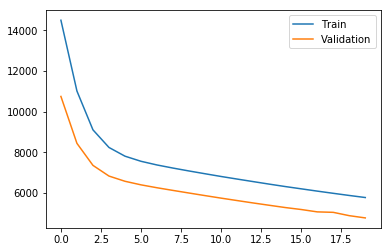

' \nResults:\n    Curves look normal. Losses decrease at an excellent rate.\n    However, the validation curve remain below throughout the epoch cycle.\n    This is an indication of underfitting.\n'

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

# write your code here

""" Building the RNN """

# Initialise the rnn model
rnn = Sequential()

# add LSTM layer 
rnn.add(LSTM(100, input_shape=(days, n_features)))
rnn.add(Activation("relu"))

# dense layer
rnn.add(Dense(1))

# compile RNN
rnn.compile(loss="mse", optimizer="adam")


""" Fitting model """

model_1 = rnn.fit_generator(
        train_generator,
        epochs = 20,
        verbose = 1,
        validation_data = val_generator
        )


""" Plotting loss curves """

plt.plot(model_1.history["loss"], label="Train")
plt.plot(model_1.history["val_loss"], label="Validation")
plt.legend()
plt.show()

""" 
Results:
    Curves look normal. Losses decrease at an excellent rate.
    However, the validation curve remain below throughout the epoch cycle.
    This is an indication of underfitting.
"""


d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

In [5]:
from sklearn.metrics import mean_squared_error

# write your code here


""" Generating predictions """

# make a prediction
preds = rnn.predict_generator(
        test_generator,
        verbose = 1
        )

# actual values
test_df = df["pm2.5"][hrs:-1]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_df.values, preds))

print("RMSE is:", rmse)

"""
Results:
    Training on a batch size of 1 yields a RMSE of ~25.92. Which is really good.
    Training on batch size of 8 yeilds a RMSE of ~63.79
"""


1095/1095 [==============================] - 1s 484us/step
RMSE is: 76.13164879334145


'\nResults:\n    Training on a batch size of 1 yields a RMSE of ~25.92. Which is really good.\n    Training on batch size of 8 yeilds a RMSE of ~63.79\n'

e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/20
3942/3942 [==============================] - 29s 7ms/step - loss: 10020.7325 - val_loss: 5356.9944
Epoch 2/20
3942/3942 [==============================] - 27s 7ms/step - loss: 4955.4658 - val_loss: 2791.6290
Epoch 3/20
3942/3942 [==============================] - 26s 7ms/step - loss: 3229.8846 - val_loss: 1778.3661
Epoch 4/20
3942/3942 [==============================] - 18s 5ms/step - loss: 2466.4518 - val_loss: 1422.7521
Epoch 5/20
3942/3942 [==============================] - 19s 5ms/step - loss: 2152.0364 - val_loss: 1128.7705
Epoch 6/20
3942/3942 [==============================] - 19s 5ms/step - loss: 1918.6014 - val_loss: 939.6073
Epoch 7/20
3942/3942 [==============================] - 20s 5ms/step - loss: 1803.3759 - val_loss: 874.9004
Epoch 8/20
3942/3942 [==============================] - 19s 5ms/step - loss: 1665.9408 - val_loss: 775.9727
Epoch 9/20
3942

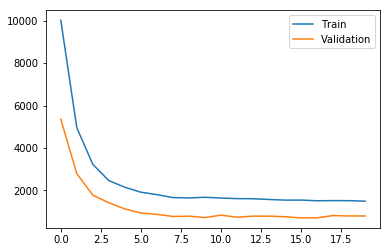

1095/1095 [==============================] - 1s 1ms/step
Improved RMSE is: 20.314009479833118


'\nResults:\n    Loss curves looking fine again. Validation curve is still below train curve\n    so there is still some underfitting.\n    Managed to decrease RMSE to ~22.07. Which is good improvement considering \n    this was run on batch size of 8. \n'

In [6]:
# write your code here


""" Creating data generators """

# batch size for training 
batch = 8

# generates time series values for train data
train_generator = TimeseriesGenerator(
        train, 
        df["pm2.5"][:val_hrs].values, 
        length=days, 
        batch_size=batch
        )

# generates time series values for validation data
val_generator = TimeseriesGenerator(
        val, 
        df["pm2.5"][val_hrs:hrs].values, 
        length=days, 
        batch_size=batch)

# generates time series values for test data
test_generator = TimeseriesGenerator(
        test, 
        df["pm2.5"][hrs:].values, 
        length=days, 
        batch_size=batch)


""" Building the improved RNN """

# Initialise the rnn model
classifier = Sequential()

# add LSTM layer 
classifier.add(LSTM(100, input_shape=(days, n_features), return_sequences=True))
classifier.add(Activation("relu"))
classifier.add(Dropout(0.25))  # helps prevent overfitting 

classifier.add(LSTM(100, input_shape=(days, n_features), return_sequences=True))
classifier.add(Activation("relu"))
classifier.add(Dropout(0.25))

classifier.add(LSTM(100, input_shape=(days, n_features)))
classifier.add(Activation("relu"))
classifier.add(Dropout(0.25))

# dense layer
classifier.add(Dense(1))

# compile RNN
classifier.compile(loss="mse", optimizer="adam")


""" Fitting improved model """

model_2 = classifier.fit_generator(
        train_generator,
        epochs = 20,
        verbose = 1,
        validation_data = val_generator
        )


""" Plotting loss curves """

plt.plot(model_2.history["loss"], label="Train")
plt.plot(model_2.history["val_loss"], label="Validation")
plt.legend()
plt.show()


""" Generating predictions """

# make a prediction
preds_2 = classifier.predict_generator(
        test_generator,
        verbose = 1
        )

# actual values
test_df = df["pm2.5"][hrs:-1]

# calculate RMSE
rmse_2 = math.sqrt(mean_squared_error(test_df.values, preds_2))

print("Improved RMSE is:", rmse_2)


"""
Results:
    Loss curves looking fine again. Validation curve is still below train curve
    so there is still some underfitting.
    Managed to decrease RMSE to ~22.07. Which is good improvement considering 
    this was run on batch size of 8. 
"""
                                           


f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

Epoch 1/20
986/986 [==============================] - 19s 19ms/step - loss: 14074.8920 - val_loss: 10772.3825
Epoch 2/20
986/986 [==============================] - 15s 15ms/step - loss: 11126.9040 - val_loss: 8409.6284
Epoch 3/20
986/986 [==============================] - 15s 15ms/step - loss: 7590.3404 - val_loss: 5086.9089
Epoch 4/20
986/986 [==============================] - 15s 15ms/step - loss: 5424.7010 - val_loss: 3628.8441
Epoch 5/20
986/986 [==============================] - 13s 14ms/step - loss: 4170.5472 - val_loss: 2758.5541
Epoch 6/20
986/986 [==============================] - 12s 12ms/step - loss: 3407.9831 - val_loss: 2198.8400
Epoch 7/20
986/986 [==============================] - 12s 12ms/step - loss: 2937.8385 - val_loss: 1855.3765
Epoch 8/20
986/986 [==============================] - 12s 12ms/step - loss: 2546.1118 - val_loss: 1500.6394
Epoch 9/20
986/986 [==============================] - 12s 12ms/step - loss: 2297.5171 - val_loss: 1493.3795
Epoch 10/20
986/986 [====

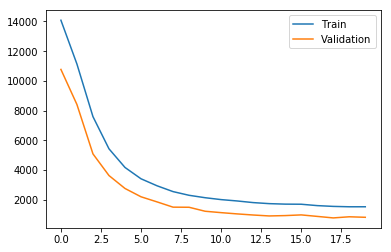

274/274 [==============================] - 2s 5ms/step
3 day model RMSE is: 34.116820458791445


'\nResults:\n    Loss curves looking fine again. Validation curve is still below train curve\n    so there is still some underfitting.\n    Managed to get RMSE to ~36.15 Which is good considering this was run on \n    batch size of 32. \n'

In [7]:
# write your code here

""" Creating data generators """

# number of days
days = 3

# batch size for training 
batch = 32

# generates time series values for train data
train_generator = TimeseriesGenerator(
        train, 
        df["pm2.5"][:val_hrs].values, 
        length=days, 
        batch_size=batch
        )

# generates time series values for validation data
val_generator = TimeseriesGenerator(
        val, 
        df["pm2.5"][val_hrs:hrs].values, 
        length=days, 
        batch_size=batch)

# generates time series values for test data
test_generator = TimeseriesGenerator(
        test, 
        df["pm2.5"][hrs:].values, 
        length=days, 
        batch_size=batch)


""" Building the improved RNN """

# Initialise the rnn model
rnn_3 = Sequential()

# add LSTM layer 
rnn_3.add(LSTM(100, input_shape=(days, n_features), return_sequences=True))
rnn_3.add(Activation("relu"))
rnn_3.add(Dropout(0.25))  # helps prevent overfitting 

rnn_3.add(LSTM(100, input_shape=(days, n_features), return_sequences=True))
rnn_3.add(Activation("relu"))
rnn_3.add(Dropout(0.25))

rnn_3.add(LSTM(100, input_shape=(days, n_features), return_sequences=True))
rnn_3.add(Activation("relu"))
rnn_3.add(Dropout(0.25))

rnn_3.add(LSTM(100, input_shape=(days, n_features)))
rnn_3.add(Activation("relu"))
rnn_3.add(Dropout(0.25))

# dense layer
rnn_3.add(Dense(1))

# compile RNN
rnn_3.compile(loss="mse", optimizer="adam")


""" Fitting improved model """

model_3 = rnn_3.fit_generator(
        train_generator,
        epochs = 20,
        verbose = 1,
        validation_data = val_generator
        )


""" Plotting loss curves """

plt.plot(model_3.history["loss"], label="Train")
plt.plot(model_3.history["val_loss"], label="Validation")
plt.legend()
plt.show()


""" Generating predictions """

# make a prediction
preds_3 = rnn_3.predict_generator(
        test_generator,
        verbose = 1
        )

# actual values
test_df = df["pm2.5"][hrs:-3]

# calculate RMSE
rmse_3 = math.sqrt(mean_squared_error(test_df.values, preds_3))

print("3 day model RMSE is:", rmse_3)

"""
Results:
    Loss curves looking fine again. Validation curve is still below train curve
    so there is still some underfitting.
    Managed to get RMSE to ~36.15 Which is good considering this was run on 
    batch size of 32. 
"""